# Dense network including textures

In this notebook, I will use 3D images __and__ textures to classify the objects in the dataset. However, not all objects in the dataset have a texture. Notably, none of the Neolithic objects has a texture, therefore this classifier has 4 output classes: Bronze Age, Iron Age, Greek and Roman.

I willl proceed as follows:
* Filter the dataset, keeping only the entries that have a texture.
* Compute a "most-common" baseline for the filtered data
* Train and evaluate an ensemble of 4 classifiers (fig. 1), one for each 3D view and one for textures, using the filtered data.

<img src="fig/ML.png">

_Figure 1: Overview of the classifier ensemble using 3D views and textures._


## Load and filter feature data
Load the feature data extracted from the 3D-views in notebook 3, filter the data, keeping only the objects that have a texture.

In [1]:
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder

PROD_DIR = 'production' # interim production files

metadata_textures = {}
# Reload texture metadata and extracted features from train dataset
with np.load(os.path.join(PROD_DIR, 'features_textures_train.npz'), allow_pickle=True) as data:
    data_dict = dict(data.items())
    metadata_textures['train'] = data_dict['metadata']
    textures_train = data_dict['textures_features']
    
# Reload texture metadata and extracted features from validation dataset
with np.load(os.path.join(PROD_DIR, 'features_textures_validate.npz'), allow_pickle=True) as data:
    data_dict = dict(data.items())
    metadata_textures['valid'] = data_dict['metadata']
    textures_valid = data_dict['textures_features']

# Reload texture metadata and extracted features from test dataset
with np.load(os.path.join(PROD_DIR, 'features_textures_test.npz'), allow_pickle=True) as data:
    data_dict = dict(data.items())
    metadata_textures['test'] = data_dict['metadata']
    textures_test = data_dict['textures_features']

def filter_objects(dataset_name, metadata_3D, dataset_3D):
    """
    @param dataset_name string 'train', 'validate', or 'test'
    @param metadata_3D numpy.ndarray metadata of 3D images
    @param dataset_3D numpy.ndarray of extracted features from 3D images
    @return numpy.ndarray filtered extracted features
    """
    idx = [row[0] in metadata_textures[dataset_name] for row in metadata_3D]
    return dataset_3D[idx]

    
# Reload extracted 3D features from train dataset
with np.load(os.path.join(PROD_DIR, 'features_point_clouds_train.npz'), allow_pickle=True) as data:
    data_dict = dict(data.items())
    metadata_train = data_dict['metadata']
    elevation_features_train = data_dict['elevation_features']
    plan_features_train = data_dict['plan_features']
    section_features_train = data_dict['section_features']
    
elevation_features_train = filter_objects('train', metadata_train, elevation_features_train)
plan_features_train = filter_objects('train', metadata_train, plan_features_train)
section_features_train = filter_objects('train', metadata_train, section_features_train)

# encode labels as ints
labels_train = LabelEncoder().fit_transform(metadata_textures['train'][:, 3]) # 'period' is the 3rd column
    
# Reload extracted features from validate dataset
with np.load(os.path.join(PROD_DIR, 'features_point_clouds_validate.npz'), allow_pickle=True) as data:
    data_dict = dict(data.items())
    metadata_valid = data_dict['metadata']
    elevation_features_valid = data_dict['elevation_features']
    plan_features_valid = data_dict['plan_features']
    section_features_valid = data_dict['section_features']

elevation_features_valid = filter_objects('valid', metadata_valid, elevation_features_valid)
plan_features_valid = filter_objects('valid', metadata_valid, plan_features_valid)
section_features_valid = filter_objects('valid', metadata_valid, section_features_valid)

# encode labels as ints
labels_valid = LabelEncoder().fit_transform(metadata_textures['valid'][:, 3]) # 'period' is the 3rd column

# Reload extracted features from test dataset
with np.load(os.path.join(PROD_DIR, 'features_point_clouds_test.npz'), allow_pickle=True) as data:
    data_dict = dict(data.items())
    metadata_test = data_dict['metadata']
    elevation_features_test = data_dict['elevation_features']
    plan_features_test = data_dict['plan_features']
    section_features_test = data_dict['section_features']

elevation_features_test = filter_objects('test', metadata_test, elevation_features_test)
plan_features_test = filter_objects('test', metadata_test, plan_features_test)
section_features_test = filter_objects('test', metadata_test, section_features_test)

# encode labels as ints
labels_test = LabelEncoder().fit_transform(metadata_textures['test'][:, 3]) # 'period' is the 3rd column

print('The filtered train dataset has {} objects, the filtered validation dataset {}, the filtered test dataset {}'.format(
    len(labels_train), len(labels_valid), len(labels_test)
))

The filtered train dataset has 394 objects, the filtered validation dataset 113, the filtered test dataset 61


## Baseline
Compute the "most frequent" baseline based on validation and the test datasets (as the distribution is the same, these are equal).

In [2]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(elevation_features_train, labels_train)
baseline_score_valid = dummy.score(elevation_features_valid, labels_valid)
baseline_score_test = dummy.score(elevation_features_test, labels_test)
print('The accuracy of the most frequent baseline for the validation dataset is {:.2f}, for the test dataset {:.2f}.'.format(baseline_score_valid, baseline_score_test))

The accuracy of the most frequent baseline for the validation dataset is 0.58, for the test dataset 0.56.


## Define dense networks

For each of the 3D-views and the texture image, I implemented a dense network with the same architecture as in te previous notebook, i.e.:

* The input data for the network are 2048 high-level features extracted from each of the 3d-views in the previous notebook.
* The data is not linearly separable (notebook 3), therefore this network needs at least one hidden layer. After some experimenting, I added two hidden layers. Chosing the number of nodes in the hidden layer is a problem for which [some heristics](http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-10.html) exist, but no definitive answer, therefore I optimize the number of nodes in the hidden layers using grid search. In this network, the second hidden layer has half the nodes of the first hidden layer.
* I added dropout layers with a dropout rate between 0.5 and 0.6, to prevent overfitting. This range [seems to cover reasonable values](https://www.machinecurve.com/index.php/2019/12/16/what-is-dropout-reduce-overfitting-in-your-neural-networks/).
* The images are in 6 classes ('Bronze Age', 'Iron Age', etc.), therefore the network requires 6 outputs.

I chose to implement the network using Keras.

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import activations
from tensorflow.keras import initializers

def define_network(outputs, hidden_nodes, rate):
    """
    Defines a multi-layer dense network with a hidden and a dropout layer.
    @param out_nodes: int, number of outputs
    @param hidden_nodes: int, number of nodes in the hidden layer
    @param rate: float, rate of the dropout layer
    """
    network = Sequential()
    # hidden layer 1
    network.add(
        Dense(
            hidden_nodes, 
            activation='relu', 
            kernel_initializer=initializers.VarianceScaling(scale=2.0, seed=0)
        )
    )
    # dropout layer
    network.add(
        keras.layers.Dropout(rate, seed=0)
    )
    # hidden layer 2
    network.add(
        Dense(
            np.floor(hidden_nodes/2), 
            activation='relu', 
            kernel_initializer=initializers.VarianceScaling(scale=2.0, seed=0)
        )
    )
    # dropout layer
    network.add(
        keras.layers.Dropout(rate, seed=0)
    )
    # output layer
    network.add(
        Dense(
            outputs, # number of image classes
            activation='softmax', # 'softmax' since output layer for classification network
            kernel_initializer=initializers.VarianceScaling(scale=1.0, seed=0)
        )
    )
    return network

### Grid search
As in the previous notebook, the networks are trained independently from each other, however this time there are 4 networks, one for each 3D view and one for the textures. I used grid search to tune the number of nodes in the hidden layer of each network and the optimizer used for compiling the model. I applied class weighting to compensate for imbalanced data.

In [5]:
import pandas as pd
from sklearn.model_selection import ParameterGrid
from sklearn.utils import class_weight

# create a grid of tunable parameters
# the same grid is used for all networks
grid = ParameterGrid({
    'nw__num_nodes': [2**i for i in range(6, 12)], # between 64 and 2048
    'nw__dropout_rate': [0.5, 0.55, 0.6],
    'nw__optimizer': ['sgd', 'adam'] # try 2 optimizers: stochastic gradient descent and Adam
})

# callback for early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=12)

def fit_network(num_nodes, optimizer, dropout_rate, X_train, y_train, X_valid, y_valid):
    """
    Fit a network as defined in define_network().
    @param num_nodes int, number of nodes in the hidden layer
    @param optimizer string name of a tf.keras.optimizers.*
    @params X_train, y_train, X_valid, y_valid numpy ndarrays
    @return fitted tensorflow network ('Sequential' object), tensorflow fit history ('History' object)
    """
    # define and compile the model with given number of nodes, dropout rate and optimizer
    outputs = 6
    network = define_network(outputs, num_nodes, dropout_rate) 
    network.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc']) # 
    # combine train and validate datasets, they will be separated using a weighted split
    X = np.concatenate([X_train, X_valid])
    y = np.concatenate([y_train, y_valid])
    # compute class weights, as dataset is imbalanced
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y), y)
    # fit network on training set, compute accuracy on validation set (from notebook 3)
    history = network.fit(
        x=X,
        y=y,
        class_weight=class_weights,
        validation_split=0.2, 
        batch_size=128, # using default batch size
        epochs=1000, # combine many epochs with early stopping
        callbacks=[early_stopping],
        shuffle=True,
        verbose=0
    )
    return network, history

def optimize_params(X_train, y_train, X_valid, y_valid):
    """
    Optimize the number of nodes in the hidden layer and the dropout rate of the network defined in define_network().
    @params X_train, y_train, X_valid, y_valid numpy ndarrays
    @return best_num_nodes int, best_rate float, accuracy Pandas DataFrame
    """
    test_scores = []
    for params_dict in grid:
        network, history = fit_network(
            params_dict['nw__num_nodes'], # keras API is not compatible with ParameterGrid, so read grid parameters by hand 
            params_dict ['nw__optimizer'],
            params_dict['nw__dropout_rate'],
            X_train, y_train, X_valid, y_valid)
        params_dict['accuracy'] = history.history['val_acc'][-1] # the validation accuracy of the model, last epoch
        test_scores.append(params_dict)

    accuracy_df = pd.DataFrame(test_scores)
    accuracy_df.sort_values(by='accuracy', ascending=False, inplace=True)
    best_dropout_rate = accuracy_df.loc[accuracy_df['accuracy'].idxmax(), 'nw__dropout_rate']
    best_num_nodes = accuracy_df.loc[accuracy_df['accuracy'].idxmax(), 'nw__num_nodes']
    best_optimizer = accuracy_df.loc[accuracy_df['accuracy'].idxmax(), 'nw__optimizer']
    return best_dropout_rate, best_num_nodes, best_optimizer, accuracy_df

#### Optimizing parameters for elevation view

In [11]:
best_dropout_rate_elevation, best_num_nodes_elevation, best_optimizer_elevation, elevation_accuracy = optimize_params(elevation_features_train, labels_train, elevation_features_valid, labels_valid)
print(elevation_accuracy.head(10), '\n')
print('Best parameters for elevation view: dropout rate {}, nodes in hidden layer {}, optimizer "{}"\n'.format(best_dropout_rate_elevation, best_num_nodes_elevation, best_optimizer_elevation))

    accuracy  nw__dropout_rate  nw__num_nodes nw__optimizer
31  0.794118              0.60            512          adam
25  0.794118              0.60             64          adam
3   0.784314              0.50            128          adam
20  0.774510              0.55           1024           sgd
34  0.774510              0.60           2048           sgd
32  0.774510              0.60           1024           sgd
9   0.774510              0.50           1024          adam
16  0.774510              0.55            256           sgd
13  0.764706              0.55             64          adam
19  0.764706              0.55            512          adam 

Best parameters for elevation view: dropout rate 0.6, nodes in hidden layer 512, optimizer "adam"



#### Optimizing parameters for plan view

In [13]:
best_dropout_rate_plan, best_num_nodes_plan, best_optimizer_plan, plan_accuracy = optimize_params(plan_features_train, labels_train, plan_features_valid, labels_valid)
print(plan_accuracy.head(10), '\n')
print('Best parameters for plan view: dropout rate {}, nodes in hidden layer {}, optimizer "{}"\n'.format(best_dropout_rate_plan, best_num_nodes_plan, best_optimizer_plan))

    accuracy  nw__dropout_rate  nw__num_nodes nw__optimizer
19  0.676471              0.55            512          adam
22  0.666667              0.55           2048           sgd
33  0.666667              0.60           1024          adam
1   0.666667              0.50             64          adam
34  0.656863              0.60           2048           sgd
15  0.647059              0.55            128          adam
23  0.647059              0.55           2048          adam
35  0.647059              0.60           2048          adam
8   0.637255              0.50           1024           sgd
9   0.637255              0.50           1024          adam 

Best parameters for plan view: dropout rate 0.55, nodes in hidden layer 512, optimizer "adam"



#### Optimizing parameters for section view

In [8]:
best_dropout_rate_section, best_num_nodes_section, best_optimizer_section, section_accuracy = optimize_params(section_features_train, labels_train, section_features_valid, labels_valid)
print(section_accuracy.head(10), '\n')
print('Best parameters for section view: dropout rate {}, nodes in hidden layer {}, optimizer "{}"\n'.format(best_dropout_rate_section, best_num_nodes_section, best_optimizer_section))

    accuracy  nw__dropout_rate  nw__num_nodes nw__optimizer
23  0.803922              0.55           2048          adam
21  0.803922              0.55           1024          adam
13  0.794118              0.55             64          adam
17  0.784314              0.55            256          adam
31  0.784314              0.60            512          adam
29  0.784314              0.60            256          adam
15  0.784314              0.55            128          adam
35  0.774510              0.60           2048          adam
34  0.774510              0.60           2048           sgd
30  0.774510              0.60            512           sgd 

Best parameters for section view: dropout rate 0.55, nodes in hidden layer 2048, optimizer "adam"



#### Optimizing parameters for textures

In [9]:
best_dropout_rate_textures, best_num_nodes_textures, best_optimizer_textures, textures_accuracy = optimize_params(textures_train, labels_train, textures_valid, labels_valid)
print(textures_accuracy.head(10), '\n')
print('Best parameters for textures: dropout rate {}, nodes in hidden layer {}, optimizer "{}"\n'.format(best_dropout_rate_textures, best_num_nodes_textures, best_optimizer_textures))

    accuracy  nw__dropout_rate  nw__num_nodes nw__optimizer
28  0.872549              0.60            256           sgd
2   0.852941              0.50            128           sgd
26  0.852941              0.60            128           sgd
4   0.843137              0.50            256           sgd
6   0.843137              0.50            512           sgd
21  0.843137              0.55           1024          adam
5   0.833333              0.50            256          adam
29  0.833333              0.60            256          adam
27  0.833333              0.60            128          adam
14  0.833333              0.55            128           sgd 

Best parameters for textures: dropout rate 0.6, nodes in hidden layer 256, optimizer "sgd"



### Define and fit each network
For each 3D-view, define a network with the optimal number of nodes in the hidden layer as determined in the previous step, fit the network.

In [14]:
# define and fit a network for each 3D-view and textures
elevation_network, elevation_history = fit_network(best_num_nodes_elevation, best_optimizer_elevation, best_dropout_rate_elevation, elevation_features_train, labels_train, elevation_features_valid, labels_valid)
plan_network, plan_history = fit_network(best_num_nodes_plan, best_optimizer_plan, best_dropout_rate_plan, plan_features_train, labels_train, plan_features_valid, labels_valid)
section_network, section_history = fit_network(best_num_nodes_section, best_optimizer_section, best_dropout_rate_section, section_features_train, labels_train, section_features_valid, labels_valid)
textures_network, textures_history = fit_network(best_num_nodes_textures, best_optimizer_textures, best_dropout_rate_textures, textures_train, labels_train, textures_valid, labels_valid)

### Examine the networks' accuracy and loss
I plotted the accuracy and loss curves of each network (separately) to determine if the network is overfitting. 
* __Accuracy__: The training and validation curves reach a plateau as the number of epochs increases. 
* __Loss__: The validation curves don't show an increased loss as the number of epochs increases, so the models are not overfitting. 

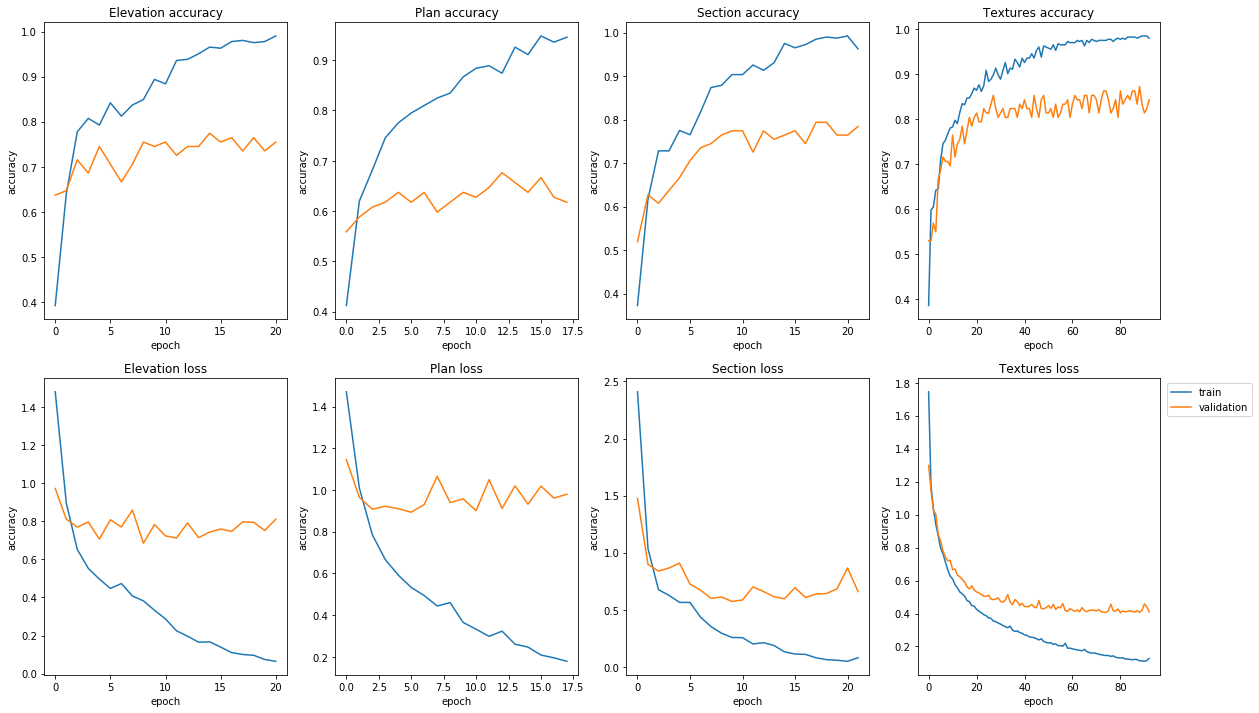

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot_accuracy(ax, history, title):
    ax.plot(history.history['acc'], label='train')
    ax.plot(history.history['val_acc'], label='validation')
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')
    ax.set_title(title)

def plot_loss(ax, history, title):
    ax.plot(history.history['loss'], label='train')
    ax.plot(history.history['val_loss'], label='validation')
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')
    ax.set_title(title)

fig, ax = plt.subplots(2, 4, figsize=(20, 12))
plot_accuracy(ax[0, 0], elevation_history, 'Elevation accuracy')
plot_accuracy(ax[0, 1], plan_history, 'Plan accuracy')
plot_accuracy(ax[0, 2], section_history, 'Section accuracy')
plot_accuracy(ax[0, 3], textures_history, 'Textures accuracy')
plot_loss(ax[1, 0], elevation_history, 'Elevation loss')
plot_loss(ax[1, 1], plan_history, 'Plan loss')
plot_loss(ax[1, 2], section_history, 'Section loss')
plot_loss(ax[1, 3], textures_history, 'Textures loss')
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
plt.show();

### Accuracy on the test set for each network

In [16]:
elevation_score = elevation_network.evaluate(elevation_features_test, labels_test, verbose=0)[1]
print('The accuracy for the network trained on the elevation views on the test set is {:.2f}'.format(elevation_score))
plan_score = plan_network.evaluate(plan_features_test, labels_test, verbose=0)[1]
print('The accuracy for the network trained on the plan views on the test set is {:.2f}'.format(plan_score))
section_score = section_network.evaluate(section_features_test, labels_test, verbose=0)[1]
print('The accuracy for the network trained on the section views on the test set is {:.2f}'.format(section_score))
textures_score = textures_network.evaluate(textures_test, labels_test, verbose=0)[1]
print('The accuracy for the network trained on the textures on the test set is {:.2f}'.format(textures_score))

The accuracy for the network trained on the elevation views on the test set is 0.79
The accuracy for the network trained on the plan views on the test set is 0.79
The accuracy for the network trained on the section views on the test set is 0.82
The accuracy for the network trained on the textures on the test set is 0.84


## Combine results
The results of the individual classifiers have to be combined into one final result for the ensemble. I tried out 2 methods to achieve this: k-nn and logistic regression.

In [17]:
# predictions for train set
pred_elevation_train = elevation_network.predict(elevation_features_train)
pred_plan_train = plan_network.predict(plan_features_train)
pred_section_train = section_network.predict(section_features_train)
pred_textures_train = textures_network.predict(textures_train)
pred_train = [np.concatenate([pred_elevation_train[i], pred_plan_train[i], pred_section_train[i], pred_textures_train[i]]) for i,_ in enumerate(labels_train)]

# predictions for validation set
pred_elevation_valid = elevation_network.predict(elevation_features_valid)
pred_plan_valid = plan_network.predict(plan_features_valid)
pred_section_valid = section_network.predict(section_features_valid)
pred_textures_valid = textures_network.predict(textures_valid)
pred_valid = [np.concatenate([pred_elevation_valid[i], pred_plan_valid[i], pred_section_valid[i], pred_textures_valid[i]]) for i,_ in enumerate(labels_valid)]

# predictions for test set
pred_elevation_test = elevation_network.predict(elevation_features_test)
pred_plan_test = plan_network.predict(plan_features_test)
pred_section_test = section_network.predict(section_features_test)
pred_textures_test = textures_network.predict(textures_test)
pred_test = [np.concatenate([pred_elevation_test[i], pred_plan_test[i], pred_section_test[i], pred_textures_test[i]]) for i,_ in enumerate(labels_test)]


### Combine using k-NN
The output of the 3d-views classifiers are 3 arrays of probabilities. Each array element contains the probabilities associated with an element in the dataset. These probabilities are an array of 6 entries, one for each class.

* The input of the final classifier is therefore an array of 18 elements
* when using k-NN, the number of neighbors can be tuned using grid search
* The output is an array of 6 elements, one for each class

Several parameters can be tuned in the scikit-learn implementation of k-NN. According to the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), these are:
* n_neighbors: the number of neighbors
* algorithm: the algorithm used to compute the nearest neighbors
* metric: the distance metric
* p: only used when algorithm is 'minkowski'
* weight: the weight of the neighbors according to the distance (not to be confused with class weight)

In [18]:
import pandas as pd
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import KNeighborsClassifier

# create a grid of tunable parameters
grid_knn = ParameterGrid([
    {
        'n_neighbors': range(1, 20),
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'metric': ['euclidean', 'manhattan', 'chebyshev']
    },
    {
        'n_neighbors': range(1, 20),
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'p': [1, 2], # L1 or L2
        'metric': ['minkowski']
    }
])

gs_results_knn = []
for params_dict in grid_knn:
    knn = KNeighborsClassifier().set_params(**params_dict) # sklearn API can set parameters directly from grid object
    knn.fit(pred_train, labels_train)
    params_dict['score'] = knn.score(pred_valid, labels_valid)
    gs_results_knn.append(params_dict)
    
gs_results_knn = pd.DataFrame(gs_results_knn)
gs_results_knn.sort_values(by='score', ascending=False).head()

,algorithm,metric,n_neighbors,p,score,weights
271,brute,manhattan,3,NaN,0.884956,distance
350,ball_tree,minkowski,3,1.0,0.884956,uniform
503,brute,minkowski,3,1.0,0.884956,distance
426,kd_tree,minkowski,3,1.0,0.884956,uniform
427,kd_tree,minkowski,3,1.0,0.884956,distance


#### Accuracy on the test set of the complete ensemble using k-NN

In [19]:
best_params = grid_knn[gs_results_knn['score'].idxmax()]
knn = KNeighborsClassifier().set_params(**best_params).fit(pred_train, labels_train)
ensemble_score_knn = knn.score(pred_test, labels_test)
print('The score for the ensemble using k-NN: {:.2f}'.format(ensemble_score_knn))

The score for the ensemble using k-NN: 0.89


### Combine using logistic regression
Inputs and outputs are the same as for k-NN, [tunable parameters](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) are 
* the inverse regularization C
* the solver algorithm. I did not use solvers saga and sag, as these were throwing too many convergence warnings
* the penalty, depending on the algorithm used

Max iterations is set to a high value, to avoid convergence warnings.

The class weight is set to 'balanced', which should adjust weights according to the class frequencies in the input data.

In [20]:
from sklearn.linear_model import LogisticRegression

# create a grid of tunable parameters
grid_logreg = ParameterGrid([
    {
        'C': np.logspace(-2, 2, num=20), # inverse regularization
        'solver': ['newton-cg', 'lbfgs'],
        'penalty': ['l2'], # these solvers no l1
        'max_iter': [2000], # avoid 'coefficient did not converge' warnings
        'class_weight': ['balanced'] # adjust weights inversely proportional to class frequencies 
    },
    {
        'C': np.logspace(-2, 2, num=20), # inverse regularization
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2'],
        'max_iter': [2000], # avoid 'coefficient did not converge' warnings
        'class_weight': ['balanced'] # adjust weights inversely proportional to class frequencies 
    },
])

gs_results_logreg = []
for params_dict in grid_logreg:
    logreg = LogisticRegression().set_params(**params_dict) # sklearn API can set parameters directly from grid object
    logreg.fit(pred_train, labels_train)
    params_dict['score'] = logreg.score(pred_valid, labels_valid)
    gs_results_logreg.append(params_dict)
    
gs_results_logreg = pd.DataFrame(gs_results_logreg)
gs_results_logreg.sort_values(by='score', ascending=False).head()


,C,class_weight,max_iter,penalty,score,solver
35,37.926902,balanced,2000,l2,0.876106,lbfgs
29,8.858668,balanced,2000,l2,0.876106,lbfgs
77,61.584821,balanced,2000,l2,0.876106,liblinear
39,100.000000,balanced,2000,l2,0.876106,lbfgs
75,37.926902,balanced,2000,l2,0.876106,liblinear


#### Accuracy on the test set of the complete ensemble using logistic regression

In [21]:
best_params = grid_logreg[gs_results_logreg['score'].idxmax()]
logreg = LogisticRegression().set_params(**best_params).fit(pred_train, labels_train)
ensemble_score_logreg = logreg.score(pred_test, labels_test)
print('The score for the ensemble using logistic regression: {:.2f}'.format(ensemble_score_logreg))

The score for the ensemble using logistic regression: 0.87


## Score comparisons

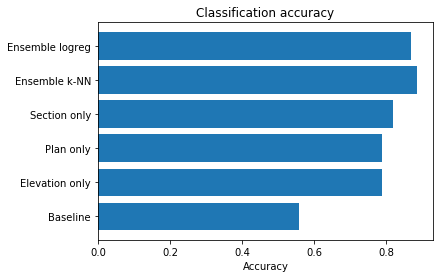

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.barh(['Baseline', 'Elevation only', 'Plan only', 'Section only', 'Ensemble k-NN', 'Ensemble logreg'], 
         width=[baseline_score_test, elevation_score, plan_score, section_score, ensemble_score_knn, ensemble_score_logreg])
plt.xlabel('Accuracy')
plt.ylabel('')
plt.title('Classification accuracy')
plt.show();